In [1]:
# -*- coding: utf-8 -*-
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments

import json
import datetime
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np 
import matplotlib as plt
from IPython.display import display
import talib as ta

import time


#自分のアカウント、トークンをセット
accountID = "101-009-16415310-001"
access_token = '860c2d2dbbcd01b6d95939b6af6b5981-8664724ce0870220c55161d704137df6'

api = API(access_token=access_token, environment="practice")

# year_months =[ [2016, 1], [2016, 2], [2016, 3], [2016, 4], [2016, 5], [2016, 6], [2016, 7], [2016, 8], [2016, 9], [2016, 10], [2016, 11], [2016, 12],
#     [2017, 1], [2017, 2], [2017, 3], [2017, 4], [2017, 5], [2017, 6], [2017, 7], [2017, 8], [2017, 9], [2017, 10], [2017, 11], [2017, 12],
#     [2018, 1], [2018, 2], [2018, 3], [2018, 4], [2018, 5], [2018, 6], [2018, 7], [2018, 8], [2018, 9], [2018, 10], [2018, 11], [2018, 12],[2019, 1], [2019, 2], [2019, 3], [2019, 4], [2019, 5], [2019, 6], [2019, 7]]

## Oandaからcandleデータを取得する。 時差のため、現在のレート取得のため、-9h
def getCandleDataFromOanda(instrument, api, date_from, date_to, granularity):
    params = {
        "from": date_from.isoformat(),
        "to": date_to.isoformat(),
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    return api.request(r)

def oandaJsonToPythonList(JSONRes):
    
    #adjust = datetime.timedelta(hours=-4)
    adjust = datetime.timedelta(hours=9) #GMT to JPN
    
    data = []
    for res in JSONRes['candles']:
        temp = [datetime.datetime.fromisoformat(res['time'][:19]) + adjust] #indexとなる時間を追加
        
        temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).hour]) #時間を追加
        
        month = datetime.datetime.fromisoformat(res['time'][:19]).month
        
        for i in range(1,13):
           
            if(month==i):
                temp.extend([1]) #月をonehotで追加
                #time.sleep(0.1)
            else:
                temp.extend([0])
                
        temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).day])  #日を追加
        
        weekday = datetime.datetime.fromisoformat(res['time'][:19]).weekday
        
        for i in range(0,7):
            
            if(weekday==i):
                temp.extend([1]) #曜日をonehotで追加
                #time.sleep(0.00001)
            else:
                temp.extend([0])
        
        temp.extend([res['volume'],
            res['mid']['o'],
            res['mid']['h'],
            res['mid']['l'],
            res['mid']['c'],
            ])
        data.append(temp)
    return data



all_data = []
# year, monthでループ
#for year, month in year_months:

NY = datetime.timedelta(hours=-13) + datetime.timedelta(seconds=-1)#レートは時差を考慮して取得

# -13hしないと"This time is future"となることから、入力した時間はNY時間として認識される。


bias = datetime.timedelta(days=0)


date_from = datetime.datetime.now() + NY + datetime.timedelta(minutes=-50000) + bias
date_to =  datetime.datetime.now() + NY +bias

print("入力はNY(-13h)で行う。これにより最新のレートが取得できる。")
print("JPN: "+str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M')))
print("NY: FROM "+str(date_from)+" TO "+str(date_to))
#print("GMT(index): "+str(date_from+datetime.timedelta(hours=4))+" "+str(date_to+datetime.timedelta(hours=4)))

ret = getCandleDataFromOanda("USD_JPY", api, date_from, date_to, "M10")
twohours_data = oandaJsonToPythonList(ret)#取得したデータを格納



all_data.extend(twohours_data)#データを追加

#print(all_data)

#ここからall_dataに追加すればよい


# pandas DataFrameへ変換
now_df = pd.DataFrame(all_data)
now_df.columns = ['Datetime',"hour_range",
              "January","February","March","April","May","June","July","August","September","October","November","December",
              "day",
              "Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday",
              'Volume', 'Open', 'High', 'Low', 'Close']
now_df = now_df.set_index('Datetime')

#print(now_df)

def adjust_now_data(df, num=1):
    
    df = df.astype(float)
    
    #以降全ての計算でレート終値を使う
    close = np.array(df["Close"])
    
    
    #特徴量を入れるための空のdataframeを作成
    df_feature = pd.DataFrame(columns=[ 
        "Close",
        "hour_range",
        #"January","February","March","April","May","June",
        #"July","August","September","October","November","December",
        "day",
        #"Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday",
        "SMA_hour/current",
        "SMA_2hour/current",
        "RSI",
        "MACD",
        "BBANDS+2σ",
        "BBANDS-2σ",
        ])

    df_feature["Close"] = df["Close"]
    df_feature["hour_range"] = df["hour_range"]
    
#     df_feature["January"] = df["January"]
#     df_feature["February"] = df["February"]
#     df_feature["March"] = df["March"]
#     df_feature["April"] = df["April"]
#     df_feature["May"] = df["May"]
#     df_feature["June"] = df["June"]
#     df_feature["July"] = df["July"]
#     df_feature["August"] = df["August"]
#     df_feature["September"] = df["September"]
#     df_feature["October"] = df["October"]
#     df_feature["November"] = df["November"]
#     df_feature["December"] = df["December"]
    
    #print(df_feature.isnull().any())
    
    #print(df_feature.isnull().any())
    
#     days=["Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday"]
#     for i in days:
#         df_feature[i] = df[i]

#     df_feature["Sunday"] = df["Sunday"]
#     df_feature["Monday"] = df["Monday"]
#     df_feature["Thuesday"] = df["Thuesday"]
#     df_feature["Wednesday"] = df["Wednesday"]
#     df_feature["Thursday"] = df["Thursday"]
#     df_feature["Friday"] = df["Friday"]
#     df_feature["Saturday"] = df["Saturday"]
    
    
    
    df_feature["day"] = df["day"]

    
    
    
    #以下、talibを用いてテクニカル指標（今回の学習で用いる特徴量）を算出しdf_feature入れる

    #単純移動平均は、単純移動平均値とその日の終値の比を特徴量として用いる
    df_feature["SMA_hour/current"]= ta.SMA(close, timeperiod=6) / close
    df_feature["SMA_2hour/current"]= ta.SMA(close, timeperiod=12) / close

    #RSI
    df_feature["RSI"] = ta.RSI(close, timeperiod=12)

    #MACD
    df_feature["MACD"], _ , _= ta.MACD(close, fastperiod=3, slowperiod=18, signalperiod=9)

    #ボリンジャーバンド 
    upper, middle, lower = ta.BBANDS(close, timeperiod=20, nbdevup=3, nbdevdn=3)
    df_feature["BBANDS+2σ"] = upper / close
    df_feature["BBANDS-2σ"] = lower / close

    
    
    #WMA
    df_feature["RSI"] = ta.WMA(close)
    
    #EMA
    df_feature["EMA"] = ta.EMA(close)
    
    #DEMA
    df_feature["DEMA"] = ta.DEMA(close)
    
    #TEMA
    df_feature["TEMA"] = ta.T3(close)
    
    #TMA
    df_feature["TMA"] = ta.TRIMA(close)
    
    #KAMA
    df_feature["KAMA"] = ta.KAMA(close)
    
    #HT_TRENDLINE
    df_feature["HT_TRENDLINE"] = ta.HT_TRENDLINE(close)
    
    #MIDPOINT
    df_feature["MIDPOINT"] = ta.MIDPOINT(close)
    
    #ROC
    df_feature["ROC"] = ta.ROCP(close)
    
    
    c=[0,0,0]
    
    
    def classify(x):

        if x<0:
            c[0]+=1
            return 0
        elif 0<=x:
            c[1]+=1
            return 1
        else:
            c[2] +=1

    legs = 60
    
    classified = pd.DataFrame(columns=["class"])
    classified["class"] = (df["Close"].pct_change(int(legs/10))*100).apply(lambda x: classify(x))

    #classified = classified.shift(-1)
    classified = classified.shift(-int(legs/10))
    
    
    #df_adjusted=df_feature[30:len(df_feature)-2]
    #classified=classified[30:len(classified)-2]
    df_adjusted=df_feature[70:len(df_feature)-int(legs/10)]
    classified=classified[70:len(classified)-int(legs/10)]
    
    
    print("[down/up]")
    print(c)
    
    
    #print(df_adjusted, classified)
    
    return df_adjusted, classified


from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
import pickle

def predict(now_df, filename = 'RF_01.sav'):
    
    day = 1
    
    data_num = 6*24*day #60分×24時間×days 間での予測精度を表示
    
    
    print("Recent 50minutes rate")
    print(now_df["Close"].tail())
    print("")
    
    
    X_now, y_now = adjust_now_data(now_df)

    #print(X_now, y_now)

    loaded_model = pickle.load(open(filename, 'rb'))

    #result = loaded_model.score(X_now, y_now)

    print("The following is the accuracy during "+str(day)+"days.")
    
    from sklearn.metrics import accuracy_score
    
    print("accuracy_score: ", end="")
    print(accuracy_score(loaded_model.predict(X_now)[:data_num-6], y_now["class"].values[:data_num-6]))
    
    from sklearn.metrics import precision_score
    print("precision_score: ", end="")
    print(precision_score(loaded_model.predict(X_now)[:data_num-6], y_now["class"].values[:data_num-6], average=None))
    
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y_now["class"].values[:data_num-6], loaded_model.predict(X_now)[:data_num-6]))
    
    return loaded_model.predict(X_now)

result = predict(now_df)



if result[-1] == 1:
    next_rate = "UP"
elif result[-1] == 0:
    next_rate = "DOWN"
print("next is ", end="")   
print(next_rate)



入力はNY(-13h)で行う。これにより最新のレートが取得できる。
JPN: 2020-10-07 13:27
NY: FROM 2020-09-02 07:07:41.756512 TO 2020-10-07 00:27:41.756512
Recent 50minutes rate
Datetime
2020-10-07 12:40:00    105.694
2020-10-07 12:50:00    105.695
2020-10-07 13:00:00    105.692
2020-10-07 13:10:00    105.693
2020-10-07 13:20:00    105.691
Name: Close, dtype: object

[down/up]
[1722, 1828, 6]
The following is the accuracy during 1days.
accuracy_score: 

ValueError: Number of features of the model must match the input. Model n_features is 11 and input n_features is 17 

In [35]:
# -*- coding: utf-8 -*-
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments

import json
import datetime
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np 
import matplotlib as plt
from IPython.display import display
import talib as ta

import time


#自分のアカウント、トークンをセット
accountID = "101-009-16415310-001"
access_token = '860c2d2dbbcd01b6d95939b6af6b5981-8664724ce0870220c55161d704137df6'

api = API(access_token=access_token, environment="practice")

# year_months =[ [2016, 1], [2016, 2], [2016, 3], [2016, 4], [2016, 5], [2016, 6], [2016, 7], [2016, 8], [2016, 9], [2016, 10], [2016, 11], [2016, 12],
#     [2017, 1], [2017, 2], [2017, 3], [2017, 4], [2017, 5], [2017, 6], [2017, 7], [2017, 8], [2017, 9], [2017, 10], [2017, 11], [2017, 12],
#     [2018, 1], [2018, 2], [2018, 3], [2018, 4], [2018, 5], [2018, 6], [2018, 7], [2018, 8], [2018, 9], [2018, 10], [2018, 11], [2018, 12],[2019, 1], [2019, 2], [2019, 3], [2019, 4], [2019, 5], [2019, 6], [2019, 7]]

## Oandaからcandleデータを取得する。 時差のため、現在のレート取得のため、-9h
def getCandleDataFromOanda(instrument, api, date_from, date_to, granularity):
    params = {
        "from": date_from.isoformat(),
        "to": date_to.isoformat(),
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    return api.request(r)

def oandaJsonToPythonList(JSONRes):
    
    #adjust = datetime.timedelta(hours=-4)
    adjust = datetime.timedelta(hours=9) #GMT to JPN
    
    data = []
    for res in JSONRes['candles']:
        temp = [datetime.datetime.fromisoformat(res['time'][:19]) + adjust] #indexとなる時間を追加
        
        temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).hour]) #時間を追加
        
#         month = datetime.datetime.fromisoformat(res['time'][:19]).month
        
#         for i in range(1,13):
           
#             if(month==i):
#                 temp.extend([1]) #月をonehotで追加
#                 #time.sleep(0.1)
#             else:
#                 temp.extend([0])
                
        temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).day])  #日を追加
        
#         weekday = datetime.datetime.fromisoformat(res['time'][:19]).weekday
        
#         for i in range(0,7):
            
#             if(weekday==i):
#                 temp.extend([1]) #曜日をonehotで追加
#                 #time.sleep(0.00001)
#             else:
#                 temp.extend([0])
        
        temp.extend([res['volume'],
            res['mid']['o'],
            res['mid']['h'],
            res['mid']['l'],
            res['mid']['c'],
            ])
        data.append(temp)
    return data



all_data = []
# year, monthでループ
#for year, month in year_months:

NY = datetime.timedelta(hours=-13) + datetime.timedelta(seconds=-1)#レートは時差を考慮して取得

# -13hしないと"This time is future"となることから、入力した時間はNY時間として認識される。


bias = datetime.timedelta(days=0)


date_from = datetime.datetime.now() + NY + datetime.timedelta(minutes=-50000) + bias
date_to =  datetime.datetime.now() + NY +bias

print("入力はNY(-13h)で行う。これにより最新のレートが取得できる。")
print("JPN: "+str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M')))
print("NY: FROM "+str(date_from)+" TO "+str(date_to))
#print("GMT(index): "+str(date_from+datetime.timedelta(hours=4))+" "+str(date_to+datetime.timedelta(hours=4)))

ret = getCandleDataFromOanda("USD_JPY", api, date_from, date_to, "M10")
twohours_data = oandaJsonToPythonList(ret)#取得したデータを格納



all_data.extend(twohours_data)#データを追加

#print(all_data)

#ここからall_dataに追加すればよい


# pandas DataFrameへ変換
now_df = pd.DataFrame(all_data)
now_df.columns = ['Datetime',"hour_range",
              #"January","February","March","April","May","June","July","August","September","October","November","December",
              "day",
              #"Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday",
              'Volume', 'Open', 'High', 'Low', 'Close']
now_df = now_df.set_index('Datetime')

#print(now_df)

def adjust_now_data(df, num=1):
    
    df = df.astype(float)
    
    #以降全ての計算でレート終値を使う
    close = np.array(df["Close"])
    
    
    #特徴量を入れるための空のdataframeを作成
    df_feature = pd.DataFrame(columns=[ 
        "Close",
        "hour_range",
        #"January","February","March","April","May","June",
        #"July","August","September","October","November","December",
        "day",
        #"Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday",
        "SMA_hour/current",
        "SMA_2hour/current",
        "RSI",
        "MACD",
        "BBANDS+2σ",
        "BBANDS-2σ",
        ])

    df_feature["Close"] = df["Close"]
    df_feature["hour_range"] = df["hour_range"]
    
#     df_feature["January"] = df["January"]
#     df_feature["February"] = df["February"]
#     df_feature["March"] = df["March"]
#     df_feature["April"] = df["April"]
#     df_feature["May"] = df["May"]
#     df_feature["June"] = df["June"]
#     df_feature["July"] = df["July"]
#     df_feature["August"] = df["August"]
#     df_feature["September"] = df["September"]
#     df_feature["October"] = df["October"]
#     df_feature["November"] = df["November"]
#     df_feature["December"] = df["December"]
    
    #print(df_feature.isnull().any())
    
    #print(df_feature.isnull().any())
    
#     days=["Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday"]
#     for i in days:
#         df_feature[i] = df[i]

#     df_feature["Sunday"] = df["Sunday"]
#     df_feature["Monday"] = df["Monday"]
#     df_feature["Thuesday"] = df["Thuesday"]
#     df_feature["Wednesday"] = df["Wednesday"]
#     df_feature["Thursday"] = df["Thursday"]
#     df_feature["Friday"] = df["Friday"]
#     df_feature["Saturday"] = df["Saturday"]
    
    
    
    df_feature["day"] = df["day"]

    
    
    
    #以下、talibを用いてテクニカル指標（今回の学習で用いる特徴量）を算出しdf_feature入れる

    #単純移動平均は、単純移動平均値とその日の終値の比を特徴量として用いる
    df_feature["SMA_hour/current"]= ta.SMA(close, timeperiod=6) / close
    df_feature["SMA_2hour/current"]= ta.SMA(close, timeperiod=12) / close

    #RSI
    df_feature["RSI"] = ta.RSI(close, timeperiod=12)

    #MACD
    df_feature["MACD"], _ , _= ta.MACD(close, fastperiod=3, slowperiod=18, signalperiod=9)

    #ボリンジャーバンド 
    upper, middle, lower = ta.BBANDS(close, timeperiod=20, nbdevup=3, nbdevdn=3)
    df_feature["BBANDS+2σ"] = upper / close
    df_feature["BBANDS-2σ"] = lower / close

    
    
#     #WMA
#     df_feature["RSI"] = ta.WMA(close)
    
#     #EMA
#     df_feature["EMA"] = ta.EMA(close)
    
#     #DEMA
#     df_feature["DEMA"] = ta.DEMA(close)
    
#     #TEMA
#     df_feature["TEMA"] = ta.T3(close)
    
#     #TMA
#     df_feature["TMA"] = ta.TRIMA(close)
    
    #KAMA
    df_feature["KAMA"] = ta.KAMA(close)
    
#     #HT_TRENDLINE
#     df_feature["HT_TRENDLINE"] = ta.HT_TRENDLINE(close)
    
#     #MIDPOINT
#     df_feature["MIDPOINT"] = ta.MIDPOINT(close)
    
    #ROC
    df_feature["ROC"] = ta.ROCP(close)
    
    
    c=[0,0,0]
    
    
    def classify(x):

        if x<0:
            c[0]+=1
            return 0
        elif 0<=x:
            c[1]+=1
            return 1
        else:
            c[2] +=1

    legs = 60
    
    classified = pd.DataFrame(columns=["class"])
    classified["class"] = (df["Close"].pct_change(int(legs/10))*100).apply(lambda x: classify(x))

    #classified = classified.shift(-1)
    classified = classified.shift(-int(legs/10))
    
    
    #df_adjusted=df_feature[30:len(df_feature)-2]
    #classified=classified[30:len(classified)-2]
    df_adjusted=df_feature[70:len(df_feature)-int(legs/10)]
    classified=classified[70:len(classified)-int(legs/10)]
    
    
    print("[down/up]")
    print(c)
    
    
    #print(df_adjusted, classified)
    
    return df_adjusted, classified


from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
import pickle

def predict(now_df, filename = 'RF_12.sav'):
    
    day = 10
    
    data_num = 6*24*day #60分×24時間×days 間での予測精度を表示
    
    
    print("Recent 50minutes rate")
    print(now_df["Close"].tail())
    print("")
    
    
    X_now, y_now = adjust_now_data(now_df)

    #print(X_now, y_now)

    loaded_model = pickle.load(open(filename, 'rb'))

    #result = loaded_model.score(X_now, y_now)

    print("The following is the accuracy during "+str(day)+"days.")
    
    result = loaded_model.predict(X_now)
    
    from sklearn.metrics import accuracy_score
    
    print("accuracy_score: ", end="")
    print(accuracy_score(result[:data_num-6], y_now["class"].values[:data_num-6]))
    
    from sklearn.metrics import precision_score
    print("precision_score: ", end="")
    print(precision_score(result[:data_num-6], y_now["class"].values[:data_num-6], average=None))
    
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y_now["class"].values[:data_num-6], result[:data_num-6]))
    
#     import matplotlib.pyplot as plt
    
#     plt.figure(figsize=(50,5))
    
#     for x in range(0,data_num-6):
#         if y_now["class"].values[x] == result[x]:
#             color = 'blue'
#         else:
#             color = 'red'
            
#         #plt.plot(X_now.index.values[x], X_now["Close"].values[x], color=color)
#         plt.scatter(X_now.index.values[x], X_now["Close"].values[x], color=color)
    
#     plt.xticks(rotation=90)
    
    
#     plt.show()
    
    
    return result

result = predict(now_df)




if result[-1] == 1:
    next_rate = "UP"
elif result[-1] == 0:
    next_rate = "DOWN"
print("next is ", end="")   
print(next_rate)




入力はNY(-13h)で行う。これにより最新のレートが取得できる。
JPN: 2020-10-07 17:02
NY: FROM 2020-09-02 10:42:24.470163 TO 2020-10-07 04:02:24.470163
Recent 50minutes rate
Datetime
2020-10-07 16:20:00    105.750
2020-10-07 16:30:00    105.907
2020-10-07 16:40:00    105.910
2020-10-07 16:50:00    105.862
2020-10-07 17:00:00    105.854
Name: Close, dtype: object

[down/up]
[1709, 1841, 6]
The following is the accuracy during 10days.
accuracy_score: 0.5251046025104602
precision_score: [0.36754508 0.68443198]
[[265 456]
 [225 488]]
next is UP


入力はNY(-13h)で行う。これにより最新のレートが取得できる。
JPN: 2020-10-07 16:59
NY: FROM 2020-09-02 10:39:36.671775 TO 2020-10-07 03:59:36.671775
Recent 50minutes rate
Datetime
2020-10-07 16:10:00    1.17574
2020-10-07 16:20:00    1.17588
2020-10-07 16:30:00    1.17531
2020-10-07 16:40:00    1.17633
2020-10-07 16:50:00    1.17670
Name: Close, dtype: object

[down/up]
[1761, 1789, 6]
The following is the accuracy during 5days.
accuracy_score: 0.8479885057471265
precision_score: [0.84991274 0.84611016]
[[1461  258]
 [ 271 1490]]


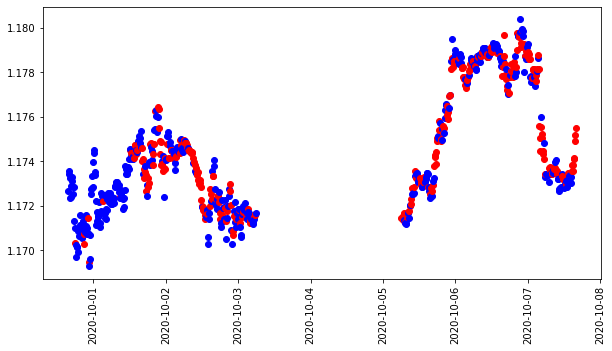

next is DOWN


In [34]:
# -*- coding: utf-8 -*-
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments

import json
import datetime
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np 
import matplotlib as plt
from IPython.display import display
import talib as ta

import time


#自分のアカウント、トークンをセット
accountID = "101-009-16415310-001"
access_token = '860c2d2dbbcd01b6d95939b6af6b5981-8664724ce0870220c55161d704137df6'

api = API(access_token=access_token, environment="practice")

# year_months =[ [2016, 1], [2016, 2], [2016, 3], [2016, 4], [2016, 5], [2016, 6], [2016, 7], [2016, 8], [2016, 9], [2016, 10], [2016, 11], [2016, 12],
#     [2017, 1], [2017, 2], [2017, 3], [2017, 4], [2017, 5], [2017, 6], [2017, 7], [2017, 8], [2017, 9], [2017, 10], [2017, 11], [2017, 12],
#     [2018, 1], [2018, 2], [2018, 3], [2018, 4], [2018, 5], [2018, 6], [2018, 7], [2018, 8], [2018, 9], [2018, 10], [2018, 11], [2018, 12],[2019, 1], [2019, 2], [2019, 3], [2019, 4], [2019, 5], [2019, 6], [2019, 7]]

## Oandaからcandleデータを取得する。 時差のため、現在のレート取得のため、-9h
def getCandleDataFromOanda(instrument, api, date_from, date_to, granularity):
    params = {
        "from": date_from.isoformat(),
        "to": date_to.isoformat(),
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    return api.request(r)

def oandaJsonToPythonList(JSONRes):
    
    #adjust = datetime.timedelta(hours=-4)
    adjust = datetime.timedelta(hours=9) #GMT to JPN
    
    data = []
    for res in JSONRes['candles']:
        temp = [datetime.datetime.fromisoformat(res['time'][:19]) + adjust] #indexとなる時間を追加
        
        temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).hour]) #時間を追加
        
#         month = datetime.datetime.fromisoformat(res['time'][:19]).month
        
#         for i in range(1,13):
           
#             if(month==i):
#                 temp.extend([1]) #月をonehotで追加
#                 #time.sleep(0.1)
#             else:
#                 temp.extend([0])
                
        temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).day])  #日を追加
        
#         weekday = datetime.datetime.fromisoformat(res['time'][:19]).weekday
        
#         for i in range(0,7):
            
#             if(weekday==i):
#                 temp.extend([1]) #曜日をonehotで追加
#                 #time.sleep(0.00001)
#             else:
#                 temp.extend([0])
        
        temp.extend([res['volume'],
            res['mid']['o'],
            res['mid']['h'],
            res['mid']['l'],
            res['mid']['c'],
            ])
        data.append(temp)
    return data



all_data = []
# year, monthでループ
#for year, month in year_months:

NY = datetime.timedelta(hours=-13) + datetime.timedelta(seconds=-1)#レートは時差を考慮して取得

# -13hしないと"This time is future"となることから、入力した時間はNY時間として認識される。


bias = datetime.timedelta(days=0)


date_from = datetime.datetime.now() + NY + datetime.timedelta(minutes=-50000) + bias
date_to =  datetime.datetime.now() + NY +bias

print("入力はNY(-13h)で行う。これにより最新のレートが取得できる。")
print("JPN: "+str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M')))
print("NY: FROM "+str(date_from)+" TO "+str(date_to))
#print("GMT(index): "+str(date_from+datetime.timedelta(hours=4))+" "+str(date_to+datetime.timedelta(hours=4)))

ret = getCandleDataFromOanda("EUR_USD", api, date_from, date_to, "M10")
twohours_data = oandaJsonToPythonList(ret)#取得したデータを格納



all_data.extend(twohours_data)#データを追加

#print(all_data)

#ここからall_dataに追加すればよい


# pandas DataFrameへ変換
now_df = pd.DataFrame(all_data)
now_df.columns = ['Datetime',"hour_range",
              #"January","February","March","April","May","June","July","August","September","October","November","December",
              "day",
              #"Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday",
              'Volume', 'Open', 'High', 'Low', 'Close']
now_df = now_df.set_index('Datetime')

#print(now_df)

def adjust_now_data(df, num=1):
    
    df = df.astype(float)
    
    #以降全ての計算でレート終値を使う
    close = np.array(df["Close"])
    
    
    #特徴量を入れるための空のdataframeを作成
    df_feature = pd.DataFrame(columns=[ 
        "Close",
        "hour_range",
        #"January","February","March","April","May","June",
        #"July","August","September","October","November","December",
        "day",
        #"Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday",
        "SMA_hour/current",
        "SMA_2hour/current",
        "RSI",
        "MACD",
        "BBANDS+2σ",
        "BBANDS-2σ",
        ])

    df_feature["Close"] = df["Close"]
    df_feature["hour_range"] = df["hour_range"]
    
#     df_feature["January"] = df["January"]
#     df_feature["February"] = df["February"]
#     df_feature["March"] = df["March"]
#     df_feature["April"] = df["April"]
#     df_feature["May"] = df["May"]
#     df_feature["June"] = df["June"]
#     df_feature["July"] = df["July"]
#     df_feature["August"] = df["August"]
#     df_feature["September"] = df["September"]
#     df_feature["October"] = df["October"]
#     df_feature["November"] = df["November"]
#     df_feature["December"] = df["December"]
    
    #print(df_feature.isnull().any())
    
    #print(df_feature.isnull().any())
    
#     days=["Sunday","Monday","Thuesday","Wednesday","Thursday","Friday","Saturday"]
#     for i in days:
#         df_feature[i] = df[i]

#     df_feature["Sunday"] = df["Sunday"]
#     df_feature["Monday"] = df["Monday"]
#     df_feature["Thuesday"] = df["Thuesday"]
#     df_feature["Wednesday"] = df["Wednesday"]
#     df_feature["Thursday"] = df["Thursday"]
#     df_feature["Friday"] = df["Friday"]
#     df_feature["Saturday"] = df["Saturday"]
    
    
    
    df_feature["day"] = df["day"]

    
    
    
    #以下、talibを用いてテクニカル指標（今回の学習で用いる特徴量）を算出しdf_feature入れる

    #単純移動平均は、単純移動平均値とその日の終値の比を特徴量として用いる
    df_feature["SMA_hour/current"]= ta.SMA(close, timeperiod=6) / close
    df_feature["SMA_2hour/current"]= ta.SMA(close, timeperiod=12) / close

    #RSI
    df_feature["RSI"] = ta.RSI(close, timeperiod=12)

    #MACD
    df_feature["MACD"], _ , _= ta.MACD(close, fastperiod=3, slowperiod=18, signalperiod=9)

    #ボリンジャーバンド 
    upper, middle, lower = ta.BBANDS(close, timeperiod=20, nbdevup=3, nbdevdn=3)
    df_feature["BBANDS+2σ"] = upper / close
    df_feature["BBANDS-2σ"] = lower / close

    
    
#     #WMA
#     df_feature["RSI"] = ta.WMA(close)
    
#     #EMA
#     df_feature["EMA"] = ta.EMA(close)
    
#     #DEMA
#     df_feature["DEMA"] = ta.DEMA(close)
    
#     #TEMA
#     df_feature["TEMA"] = ta.T3(close)
    
#     #TMA
#     df_feature["TMA"] = ta.TRIMA(close)
    
    #KAMA
    df_feature["KAMA"] = ta.KAMA(close)
    
#     #HT_TRENDLINE
#     df_feature["HT_TRENDLINE"] = ta.HT_TRENDLINE(close)
    
#     #MIDPOINT
#     df_feature["MIDPOINT"] = ta.MIDPOINT(close)
    
    #ROC
    df_feature["ROC"] = ta.ROCP(close)
    
    
    c=[0,0,0]
    
    
    def classify(x):

        if x<0:
            c[0]+=1
            return 0
        elif 0<=x:
            c[1]+=1
            return 1
        else:
            c[2] +=1

    legs = 60
    
    classified = pd.DataFrame(columns=["class"])
    classified["class"] = (df["Close"].pct_change(int(legs/10))*100).apply(lambda x: classify(x))

    #classified = classified.shift(-1)
    classified = classified.shift(-int(legs/10))
    
    
    #df_adjusted=df_feature[30:len(df_feature)-2]
    #classified=classified[30:len(classified)-2]
    df_adjusted=df_feature[70:len(df_feature)-int(legs/10)]
    classified=classified[70:len(classified)-int(legs/10)]
    
    
    print("[down/up]")
    print(c)
    
    
    #print(df_adjusted, classified)
    
    return df_adjusted, classified


from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
import pickle

def predict(now_df, filename = 'RF_EUR_USD.sav'):
    
    day = 5
    
    data_num = 6*24*day #60分×24時間×days 間での予測精度を表示
    
    
    print("Recent 50minutes rate")
    print(now_df["Close"].tail())
    print("")
    
    
    X_now, y_now = adjust_now_data(now_df)

    #print(X_now, y_now)

    loaded_model = pickle.load(open(filename, 'rb'))

    #result = loaded_model.score(X_now, y_now)

    print("The following is the accuracy during "+str(day)+"days.")
    
    result = loaded_model.predict(X_now)
    
    from sklearn.metrics import accuracy_score
    
    print("accuracy_score: ", end="")
    print(accuracy_score(result[-len(result):], y_now["class"].values[-len(result):]))
    
    from sklearn.metrics import precision_score
    print("precision_score: ", end="")
    print(precision_score(result[:len(result)], y_now["class"].values[:len(result)], average=None))
    
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y_now["class"].values[:len(result)], result[:len(result)]))
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10,5))
    
    for x in range(len(result)-data_num,len(result)):
        if y_now["class"].values[x] == result[x]:
            color = 'blue'
        else:
            color = 'red'
            
#         if result[x] == 1:
#             color = 'blue'
#         else:
#             color = 'red'
            
        #plt.plot(X_now.index.values[x], X_now["Close"].values[x], color=color)
        plt.scatter(X_now.index.values[x], X_now["Close"].values[x], color=color)
    
    plt.xticks(rotation=90)
    
    
    plt.show()
    
    
    return result

result = predict(now_df)




if result[-1] == 1:
    next_rate = "UP"
elif result[-1] == 0:
    next_rate = "DOWN"
print("next is ", end="")   
print(next_rate)



